## Advanced Lane Finding Project

The goals / steps of this project are the following:

1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
2. Apply a distortion correction to raw images.
3. Use color transforms, gradients, etc., to create a thresholded binary image.
4. Apply a perspective transform to rectify binary image ("birds-eye view").
5. Detect lane pixels and fit to find the lane boundary.
6. Determine the curvature of the lane and vehicle position with respect to center.
7. Warp the detected lane boundaries back onto the original image.
8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Load libraries

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import math
#%matplotlib qt

## Helper functions
Some helper functions are defined.

region_of_interest() is not used yet, but could be interesting to apply to make the pipeline more robust and only focus on the road area.

Additionally, helpter functions for applying Sobel filtes are defined.

In [2]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output


# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function that thresholds the S-channel of HLS
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

---
## 1. Compute camera calibration matrix and distortion coefficients given a set of chessboard images
First, I'll compute the camera calibration using chessboard images.

I start by preparing "object points", which will be the (x, y, z) coordinates of the chessboard corners in the world. Here I am assuming the chessboard is fixed on the (x, y) plane at z=0, such that the object points are the same for each calibration image.  Thus, `objp` is just a replicated array of coordinates, and `objpoints` will be appended with a copy of it every time I successfully detect all chessboard corners in a test image. `imgpoints` will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection.

I then used the output `objpoints` and `imgpoints` to compute the camera calibration and distortion coefficients using the `cv2.calibrateCamera()` function.  I applied this distortion correction to the test image using the `cv2.undistort()` function.

A total of 17 out of the 20 chessboard calibration images were succesful to use in the calibration procedure.

Getting filepaths to calibration images ...
20 calibration images found
17 / 20  image(s) used for calibration


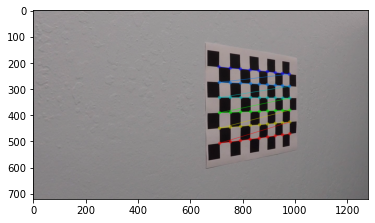

Done


In [3]:
# Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
print("========================================")
print("Getting filepaths to calibration images ...")
image_filenames = glob.glob('camera_cal/calibration*.jpg')
chess_images =[]
print(len(image_filenames), "calibration images found")

# Step through the list and search for chessboard corners
for fname in image_filenames:
    img = cv2.imread(fname)
    chess_images.append(img)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #cv2.imshow('img',img)
        #cv2.waitKey(500)

print(len(imgpoints), "/", len(image_filenames), " image(s) used for calibration")
plt.imshow(img)
plt.show()
print("========================================")
print("Done")
print("========================================")

#cv2.destroyAllWindows()

---
## 2. Apply a distortion correction to raw images

Image distortation correctionis implemented.

The `cv2.calibrateCamera()` function was used with the `objpoints` and `imgpoints` acquired in the camera calibration step.

The output values are then used with the `cv2.undistort()` function to undistort an image.

Undistorting a test image
Done


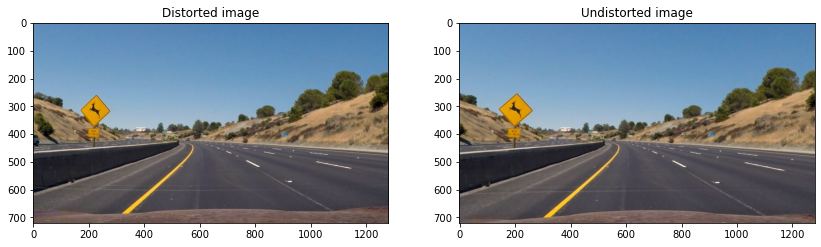

In [4]:
""" 
Test the chessboard camera calibration on on test images
found /test_images/.
"""
print("========================================")
# Load test image
#img = cv2.imread('test_images/straight_lines1.jpg')
img = cv2.imread('test_images/test2.jpg')
#img = cv2.imread('camera_cal/calibration1.jpg')

global ret
global mtx 
global dist
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1:], None, None)

def cal_undistort(img, objpoints, imgpoints):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

print("Undistorting a test image")
undistorted = cal_undistort(img, objpoints, imgpoints)

# Display test image
fig = plt.figure(figsize=(14,10))
# Show original distorted image
ax1 = fig.add_subplot(1,2,1)
ax1.set_title('Distorted image')
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
# Show undistorted (corrected) image
ax2 = fig.add_subplot(1,2,2)
ax2.set_title('Undistorted image')
ax2.imshow(cv2.cvtColor(undistorted, cv2.COLOR_BGR2RGB))

print("========================================")
print("Done")
print("========================================")

---
## 3. Create a thresholded binary image

I used a combination of color and gradient thresholds to generate a binary image. The implementation extracts the HLS colorspace, where especially the S channel seems to highlight the lane lines quite well. A Sobel filter was applied followed by a custom thresholding to select relevant pixels. This was followed by a thresholding of the S channel of HLS. Finally, the two binary output were combined to produce the final output.

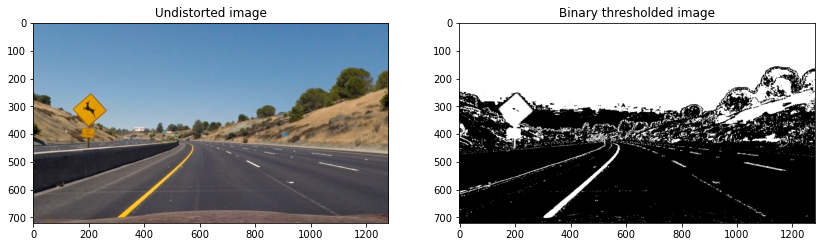

In [5]:
grad_binary = abs_sobel_thresh(undistorted, orient='x', thresh_min=30, thresh_max=120)
#plt.imshow(grad_binary, cmap='gray')
mag_binary = mag_thresh(undistorted, sobel_kernel=3, mag_thresh=(0, 255))
hls_binary = hls_select(undistorted, thresh=(100, 255))
#plt.title("HLS: S-threshold")
#plt.imshow(hls_binary, cmap='gray')

def threshold_pipeling(img, s_thresh=(90, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0, ksize=1) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    # Gradient binary (Sobel)
    #abs_sobel_binary = abs_sobel_thresh(img, orient='x', thresh_min=30, thresh_max=120)
    #mag_binary = mag_thresh(undistorted, sobel_kernel=3, mag_thresh=(0, 255))

    combined_binary = np.zeros_like(img[:,:,0])
    combined_binary[(sxbinary == 1) | (s_binary == 1)] = 255

    return combined_binary
    
binary_image = threshold_pipeling(undistorted)
#plt.imshow(binary_image, cmap='gray')

# Display test image
fig = plt.figure(figsize=(14,10))
ax1 = fig.add_subplot(1,2,1)
ax1.set_title('Undistorted image')
ax1.imshow(cv2.cvtColor(undistorted, cv2.COLOR_BGR2RGB))
ax2 = fig.add_subplot(1,2,2)
ax2.set_title('Binary thresholded image')
ax2.imshow(binary_image, cmap='gray')

## 4. Apply a perspective transform to rectify binary image ("birds-eye view")

Here perspective transform is implemented. It includes a function called `warp_img()` to perform the perspective transformation.  The `warp_img()` function takes as inputs an image (`img`), as well as source (`src_coord`) and destination (`dst_coord`) points. The source and destination points are hardcoded in src_coord and dst_coord by manually identifying specific points in the undistorted image.

Warping a test image
Done


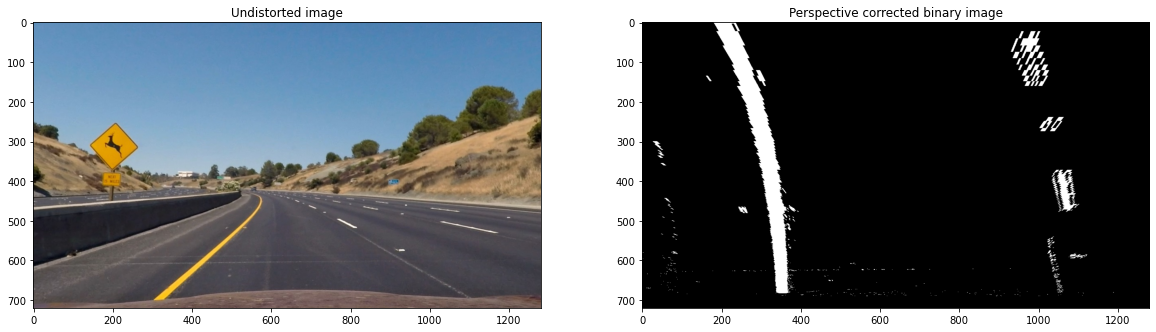

In [6]:
# Change the perspective of the image to get a birds-eye view
print("========================================")
# Four source coordinates
global src
src = np.float32([
    [837, 548],  # top right
    [1018, 667], # bottom right
    [281, 667],  # bottom left
    [454, 548]   # top left
])

# Four desired coordinates
global dst
dst = np.float32([
    [1018, 548], # top right
    [1018, 667], # bottom right
    [281, 667],  # bottom left
    [281, 548],  # top left
])

# Helper functions
def warp_img(img, src_coord, dst_coord):
    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    # Compute the perspective transform (go from src_coord to dst_coord)
    M = cv2.getPerspectiveTransform(src_coord, dst_coord)

    # Compute the inverse perspective transform (go from dst_coord to src_coord)
    # Just swap the parameters src_coord and dst_coord
    M_inv = cv2.getPerspectiveTransform(dst_coord, src_coord)

    # Create warped image - use linear interpolation
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image
    return warped, M, M_inv

def unwarp_img(img, src_coord, dst_coord):
    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    # Compute the inverse perspective transform (go from dst_coord to src_coord)
    # Just swap the parameters src_coord and dst_coord
    M_inv = cv2.getPerspectiveTransform(dst_coord, src_coord)
    # Create warped image - use linear interpolation
    unwarped = cv2.warpPerspective(img, M_inv, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image
    return unwarped


print("Warping a test image")
warped_img, M, M_inv = warp_img(binary_image, src, dst)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

ax1.set_title('Undistorted image')
ax1.imshow(cv2.cvtColor(undistorted, cv2.COLOR_BGR2RGB))
ax2.set_title('Perspective corrected binary image')
ax2.imshow(cv2.cvtColor(warped_img, cv2.COLOR_BGR2RGB))

print("========================================")
print("Done")
print("========================================")

---
## 5. Detect lane pixels and fit to find the lane boundary

First a function for detecting the lane pixels `find_lane_pixels()` is defined. It takes in a undistorted binary image from the previous step, and it outputs detected pixels that are relevant to the right and left lane line. The lane lines are detected by finding histogram peaks at the lower part of the image and using a sliding window to move across the binary image. The two most prominent peaks in the histogram will be good indicators of the x-position of the base of the lane lines. I use that as a starting point for where to search for the lane lines. From that point, I use a sliding window, placed around the line centers, to find and follow the lines up to the top of the image frame.

Then I implemented another function called `fit_polynomial()`, which also takes a binary image and then later calls `find_lane_pixels()` described above. It receives the relevant lane lines pixels from `find_lane_pixels()`. These x,y pixel values for the left and right lane line respectively, are then used for fitting a second order polynomial to each lane line. `fit_polynomial()` an image for visualization and the fitted polynomial parameters and pixels for each lane line.

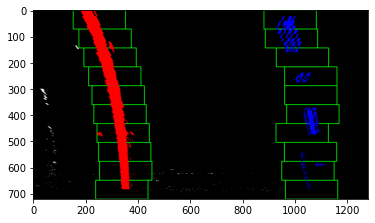

In [7]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 10
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    #return leftx, lefty, rightx, righty, out_img, left_lane_inds, right_lane_inds
    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')

    
    return out_img, left_fit, right_fit, ploty, left_fitx, right_fitx, leftx, lefty, rightx, righty

out_img, left_fit, right_fit, ploty, left_fitx, right_fitx, leftx, lefty, rightx, righty = fit_polynomial(warped_img)
plt.imshow(out_img)

#############################################################################
# Finding the lines: search from prior
# Polynomial fit values from the previous frame
# Grab the values from the previous step
#left_fit = np.array([ 2.13935315e-04, -3.77507980e-01,  4.76902175e+02])
#right_fit = np.array([4.17622148e-04, -4.93848953e-01,  1.11806170e+03])

def fit_poly(img_shape, leftx, lefty, rightx, righty):
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped, left_fit, right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    new_left_fit = np.polyfit(lefty, leftx, 2)
    new_right_fit = np.polyfit(righty, rightx, 2)



    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return out_img, new_left_fit, new_right_fit, ploty

# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
out_img, new_left_fit, new_right_fit, ploty = search_around_poly(warped_img, left_fit, right_fit)

# View your output
#plt.imshow(out_img)



---
## 6. Determine the curvature of the lane and vehicle position with respect to center

Two functions were implemented for measuring the lane curvature and vehicle postion with respect to the center of the lane.

The function `measure_curvature_real()` takes in the pixel values for the left and right lane line. Then the pixel-to-meter ration `ym_per_pix` and `xm_per_pix` are defined to calculate the real world units transformed from pixel values, since until now everything has been pixel values. It is expected as per a standard that the lane width is approximately 3.7 meters and the tracking lenght of the lane is 30 meters.

* `ym_per_pix` = 30/720 # meters per pixel in y dimension
* `xm_per_pix` = 3.7/700 # meters per pixel in x dimension

The function `measure_offset_to_center()` calculates the offset to the center of the lane by taking the two fitted polynomials for each lane line and finding the x-coordinate where they intersect with the bottom of the image frame, i.e. at y_max. The center is then calculated by finding the center point between this two x-coordinates. Finally, the value is transformed from pixel-values to real-world values in meters, and then returned.

In [8]:
def measure_curvature_real(leftx, lefty, rightx, righty, ploty):
    
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    left_fit_cr = np.polyfit(lefty * ym_per_pix, leftx * xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty * ym_per_pix, rightx * xm_per_pix, 2)

    # Define y-value where we want radius of curvature
    y_eval = np.max(ploty)

    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2 * left_fit_cr[0] * y_eval * ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2 * right_fit_cr[0] * y_eval * ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad

# The camera is assumed centered on the car, such that the lane center is the midpoint 
# at the bottom of the image between the two lines detected. The offset of the lane 
# center from the center of the image (converted from pixels to meters) is the distance from the center of the lane.
def measure_offset_to_center(ploty, left_fit, right_fit):
    y_max = np.max(ploty)
    left_x_coor = left_fit[0] * y_max**2 + left_fit[1] * y_max + left_fit[2]
    right_x_coor = right_fit[0] * y_max**2 + right_fit[1] * y_max + right_fit[2]
    lane_center_px = 1280 / 2
    center_offset_img_space = (left_x_coor + right_x_coor)/ 2 - lane_center_px

    xm_per_pix = 3.7/700
    center_offset_real_world = center_offset_img_space * xm_per_pix
    return center_offset_real_world


# Calculate the radius of curvature in meters for both lane lines
left_curverad, right_curverad = measure_curvature_real(leftx, lefty, rightx, righty, ploty)

print(left_curverad, 'm', right_curverad, 'm')

536.4186963538573 m 384.70960381435066 m


---
## 7. Warp the detected lane boundaries back onto the original image

`drawing_lane_lines()` takes an undistorted image, the binary warped image, the inverse perspective transform `M_inv`, and the lane lines pixel coordinates. `cv2.fillPoly` is used to draw the green lane area. Finally, `cv2.warpPerspective` is used to perspective transform the green lane area onto the undistorted image using the inverse perspective transform `M_inv`.

In [9]:
print("Unwarp and draw lane lines")

# Warp detected lane boundaries back onto the original image
def drawing_lane_lines(undistorted_image, binary_warped, M_inv, ploty, left_fitx, right_fitx):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warped = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warped, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warped, M_inv, (undistorted_image.shape[1], undistorted_image.shape[0])) 
    # Combine the result image with the original image
    result_image = cv2.addWeighted(undistorted_image, 1, newwarp, 0.3, 0)
    return result_image

Unwarp and draw lane lines


---
## 8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position

`drawing_lane_curvature_text()` implements a function to add text to the undistorted image. Here the lane curvature (mean of the left and right lane line) is added as well with the off center distance.

Finally, the function `plot_lane_lines_on_image()` is implemented, which puts the whole processing pipeline together. It takes in the original distorted video feed image and the does the following:

1. Undistorts the image
1. Applies thresholding to produce a binary image
1. Applies a perspective transform to provide a birds-eye view of the road and lane lines
1. Detects the lane line pixels and fits two polynomials to the pixels
1. Calculates the lane curvature for each lane line
1. Calculates the off center distance of the car
1. Draws the lane area in green onto the original undistorted image
1. Adds text information about the mean lane curvature and off center distance


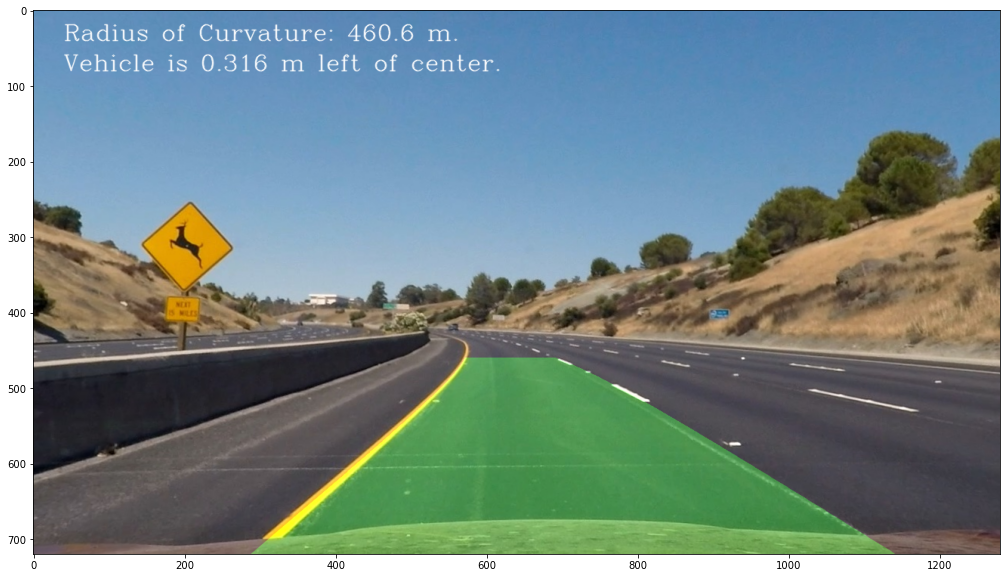

In [10]:
# Pipeline for processing image data
def drawing_lane_curvature_text(img_result, left_curverad, right_curverad, center_offset_real_world_m):
    txt_header1 = "Radius of Curvature: {:.1f} m.".format((left_curverad + right_curverad)/2)
    if center_offset_real_world_m > 0:
        txt_header2 = "Vehicle is {:.3f} m left of center.".format(np.abs(center_offset_real_world_m))
    else:
        txt_header2 = "Vehicle is {:.3f} m right of center.".format(np.abs(center_offset_real_world_m))

    cv2.putText(img_result, txt_header1, (40, 40), cv2.FONT_HERSHEY_COMPLEX, 1, (255,255,255), 1, cv2.LINE_AA)
    cv2.putText(img_result, txt_header2, (40, 80), cv2.FONT_HERSHEY_COMPLEX, 1, (255,255,255), 1, cv2.LINE_AA)
    return img_result


#def plot_lane_lines_on_image(original_image, src_points, dst_points, camera_matrix, distortion_coefficients):
def plot_lane_lines_on_image(original_image):
    global src
    global dst
    global mtx
    global dist
    
    # Undistort image
    img_undistorted = cv2.undistort(original_image, mtx, dist, None, mtx)
    
    # Binary
    img_thresholded_binary = threshold_pipeling(img_undistorted)

    # Warp image
    img_thresholded_binary_warped, M_binary, M_binary_inv = warp_img(img_thresholded_binary, src, dst)

    # Fit polynomial to lane lines
    out_img, left_fit, right_fit, ploty, left_fitx, right_fitx, leftx, lefty, rightx, righty = fit_polynomial(img_thresholded_binary_warped)

    
    # Measure curvature
    left_curverad, right_curverad = measure_curvature_real(leftx, lefty, rightx, righty, ploty)

    # Vehicle position
    center_offset_real_world_m = measure_offset_to_center(ploty, left_fit, right_fit)
    
    # Draw lane lines
    result_image = drawing_lane_lines(img_undistorted, img_thresholded_binary_warped, M_binary_inv, ploty, left_fitx, right_fitx)

    # Draw text
    result_image = drawing_lane_curvature_text(result_image, left_curverad, right_curverad, center_offset_real_world_m)

    return result_image


final_img = plot_lane_lines_on_image(img)
plt.figure(figsize = (20,10))
plt.imshow(cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB))

---
## Test on video

Finally, the whole pipeline is tested on small video clip of highway driving. The pipeline is run on each frame of the video, and finally an output.mp4 video is generated with the detected lane highlighted in greed and the curvature and off-center information.

In [11]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [12]:
white_output = 'output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip

## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/project_video.mp4").subclip(9,14)

clip1 = VideoFileClip("test_videos/project_video.mp4")
#clip1 = VideoFileClip("test_videos/challenge_video.mp4")
#clip1 = VideoFileClip("test_videos/harder_challenge_video.mp4")
white_clip = clip1.fl_image(plot_lane_lines_on_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   0%|          | 3/1260 [00:00<01:18, 16.01it/s, now=None]Moviepy - Building video output.mp4.
Moviepy - Writing video output.mp4

t: 100%|██████████| 1260/1260 [02:14<00:00,  9.63it/s, now=None]Moviepy - Done !
Moviepy - video ready output.mp4
CPU times: user 10min 43s, sys: 1min 34s, total: 12min 17s
Wall time: 2min 15s
